# Laboratory 3: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [ ]:
# We're still going to need numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import random

# Verify that pytorch is working.
import torch

# If this works, things should be OK.
print(torch.randn((3, 3)))

## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [ ]:
# Download and load the MNIST dataset.
from torchvision.datasets import MNIST
import torchvision

# Load the MNIST training and test splits.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)

In [ ]:
display(ds_train)
display(ds_test)

### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images?

Remember that one of the best ways to explore is to *visualize*.

In [ ]:
# Print some information about the dataset
print("Number of training examples:", len(ds_train))
print("Number of test examples:", len(ds_test))
print("Image size:", ds_train[0][0].size)

# Plot a few sample images from the training set
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        image, label = ds_train[i * 5 + j]
        axes[i, j].imshow(image, cmap='summer') #summer
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.show()

In [ ]:
# Create a random permutation of indices for the first 100 images in the training set
random_indices = np.random.permutation(ds_train.data.shape[0])[:100]

plt.figure(figsize=(10, 10))

# Visualize the first 100 randomly selected images from the training set
for i, index in enumerate(random_indices):
    # Subplot organization: 10 rows, 10 columns, i+1 refers to the current subplot index
    plt.subplot(10, 10, i+1)

    # Display the image with random colormap
    plt.imshow(ds_train.data[index], cmap="summer")

    
    # Set the title with the corresponding label
    plt.title(f"Label: {ds_train.targets[index]}")
    
    # Turn off axis ticks for cleaner visualization
    plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the visualization
plt.show()


commenta i colori


### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

In [ ]:
# Your code here.
import torch

Xs_train = ds_train.data.to(torch.float32)
ys_train = ds_train.targets
Xs_test = ds_test.data.to(torch.float32)
ys_test = ds_test.targets

mean_px = Xs_train.mean()
std_px = Xs_train.std()
Xs_train = (Xs_train - mean_px) / std_px
Xs_test = (Xs_test - mean_px) / std_px

Xs_train.mean(), Xs_train.std(), Xs_test.mean(), Xs_test.std()

In [ ]:
Xs_train.flatten(1).shape

In [ ]:
Xs_test.flatten(1).shape

In [ ]:
plt.imshow(Xs_train[0], cmap='gray')

### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [ ]:
# Your code here.
train_size = 10000
I = np.random.permutation(range(len(Xs_train)))[:train_size]
Xs_train_i = Xs_train[I]
ys_train_i = ys_train[I]

Xs_train_i = Xs_train_i.flatten(start_dim=1)
Xs_test_i = Xs_test.flatten(start_dim=1)

Xs_train_i.shape, Xs_test_i.shape

## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [ ]:
# Your code here.
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

max_iter = 1000

svc = LinearSVC(max_iter=max_iter)
svc.fit(Xs_train_i, ys_train_i)

preds = svc.predict(Xs_test_i)
accuracy_score(ys_test.numpy(), preds)
print("Accuracy: ", accuracy_score(ys_test, preds))

print("Classification report: ")
print(classification_report(ys_test, svc.predict(Xs_test_i)))

cm = confusion_matrix(ys_test, preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()


analisi del perchè mi venga un accuracy di 0.87

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

Xs_test = Xs_test.flatten(-2)
# Reshape the data if needed (SVC expects 2D input)
Xs_train_2d = Xs_train_i.reshape(Xs_train_i.shape[0], -1)
Xs_test_2d = Xs_test.reshape(Xs_test.shape[0], -1)

# Instantiate the Support Vector Classifier (SVC)
svc = SVC()

# Fit the model on the training data
svc.fit(Xs_train_2d, ys_train_i)

# Predict the labels for the test data
predictions = svc.predict(Xs_test)

# Calculate accuracy
accuracy = accuracy_score(ys_test.numpy(), svc.predict(Xs_test_2d))
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(predictions, ys_test))

# Confusion Matrix
cm = confusion_matrix(ys_test, predictions)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

commenta perchè questo è meglio

## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [ ]:
# Your code here.
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

ds = TensorDataset(Xs_train_i, ys_train_i)
dl_train = DataLoader(ds, batch_size=batch_size, shuffle=True)

len(dl_train)

batch = next(iter(dl_train))
print("Feature shape:", batch[0].shape)
print("Target shape:", batch[1].shape)

### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [ ]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer):
    model.train()
    losses = []
    for (xs, ys) in dl:
        optimizer.zero_grad()
        output = model(xs)
        loss = torch.nn.functional.nll_loss(output, ys) #compute the negative log likelihood loss
        loss.backward() #compute the gradient 
        optimizer.step() #tell the optimizer to perform a gradient step
        losses.append(loss.item())
    model.eval()
    return np.mean(losses)

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [ ]:
# Define a fresh model.
import torch.nn as nn

model = torch.nn.Sequential(
    # Your code here.
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)   # Specify dim=1 to apply LogSoftmax along the second dimension
)


### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate a variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

In [ ]:
# Your code here.
from tqdm import tqdm

model = torch.nn.Sequential(
    # Your code here.
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)   
)

epochs = 100
lr = 1e-2   # Learning rate
losses = []
opt = torch.optim.SGD(model.parameters(),lr=lr)

#Training loop
for epoch in tqdm(range(epochs)):
    loss = train_epoch(model, dl_train, opt)
    losses.append(train_epoch(model, dl_train, opt))
    
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


print("Classification report: ")
print(classification_report(ys_test, model(Xs_test_i).argmax(dim=1)))

### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Funzione per calcolare l'accuratezza
def compute_accuracy(model, X, y):
    predictions = torch.argmax(model(X), dim=1)
    return (predictions == y).float().mean().item()

# Funzione per allenare il modello con una combinazione di iperparametri
def train_with_hyperparameters(model, optimizer, data_loader, num_epochs):
    train_loss_curve = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, data_loader, optimizer)
        train_loss_curve.append(train_loss)
    return train_loss_curve

# Funzione principale per allenare e valutare il modello
def train_and_evaluate(model, learning_rate, batch_size, num_epochs):
    # Configurazione iperparametri
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(
        TensorDataset(Xs_train_2d, ys_train_i),
        batch_size=batch_size,
        shuffle=True
    )

    # Allenamento
    train_loss_curve = train_with_hyperparameters(model, optimizer, train_loader, num_epochs)

    # Valutazione sul test set
    test_accuracy = compute_accuracy(model, Xs_test_2d, ys_test)

    return train_loss_curve, test_accuracy

# Funzione per tracciare la curva di perdita
def plot_loss_curve(train_loss_curve, learning_rate, batch_size):
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_curve, label=f"LR: {learning_rate}, Batch: {batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Iperparametri iniziali
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 64, 256]
num_epochs = 100

# Baseline per confronto
accuracy_score_linearSVC = 0.88  # Accuracy ottenuta con LinearSVC
accuracy_score_nl_SVC = 0.96  # Supponendo un baseline di accuratezza

# Ricerca del miglior modello
best_accuracy = 0.0
best_hyperparameters = {}
best_loss_curve = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with LR: {lr}, Batch Size: {batch_size}")
        model.apply(reset_parameters)  # Resetta i pesi del modello per ogni nuova combinazione
        loss_curve, test_accuracy = train_and_evaluate(model, lr, batch_size, num_epochs)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
            best_loss_curve = loss_curve

        print(f"Test Accuracy: {test_accuracy:.4f}")

# Traccia la curva di perdita del miglior modello
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_hyperparameters['learning_rate']}, Batch Size: {best_hyperparameters['batch_size']}")
print(f"Best Test Accuracy: {best_accuracy:.4f})")

if(best_accuracy > accuracy_score_nl_SVC):
    print("The model is better than the Non-Linear SVC baseline and the Linear SVC baseline")
else:
    if(best_accuracy > accuracy_score_linearSVC):
        print("The model is better than the Linear SVC baseline")
    else:
        print("The model is worse than both baselines")

plot_loss_curve(best_loss_curve, best_hyperparameters['learning_rate'], best_hyperparameters['batch_size'])

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

In [ ]:
# Import delle librerie necessarie
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

# Dimensione dello strato nascosto
inner_size = 256

# Definizione del modello MLP con un livello nascosto
model = torch.nn.Sequential(
    nn.Linear(784, inner_size),  # Primo livello lineare
    nn.ReLU(),                   # Funzione di attivazione ReLU
    nn.Linear(inner_size, 10),   # Secondo livello lineare (uscita)
    nn.LogSoftmax(dim=1)         # Softmax per classificazione logaritmica
)

# Parametri di configurazione
epochs = 1000  # Numero di epoche
lr = 1e-3     # Learning rate
losses = []   # Per tracciare l'andamento della perdita

# Ottimizzatore e funzione di perdita
opt = torch.optim.SGD(model.parameters(), lr=lr)  # Stochastic Gradient Descent
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss per classificazione

# Ciclo di addestramento
for epoch in tqdm(range(epochs)):
    model.train()  # Modalità di addestramento
    total_loss = 0  # Inizializzazione della perdita totale
    
    for X_batch, y_batch in dl_train:  # dl_train è il dataloader di training
        opt.zero_grad()  # Reset dei gradienti
        output = model(X_batch)  # Forward pass
        loss = criterion(output, y_batch)  # Calcolo della perdita
        loss.backward()  # Backpropagation
        opt.step()  # Aggiornamento dei pesi
        total_loss += loss.item()  # Accumula la perdita
    
    # Salva la perdita media per ogni epoca
    losses.append(total_loss / len(dl_train))

# Grafico della perdita durante l'addestramento
plt.plot(losses)
plt.title('Loss Trend During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Valutazione sul test set
model.eval()  # Modalità di valutazione
with torch.no_grad():  # Disabilita il calcolo dei gradienti
    preds = torch.argmax(model(Xs_test_i), dim=1)  # Predizioni
    print(classification_report(ys_test, preds))  # Report di classificazione

100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]

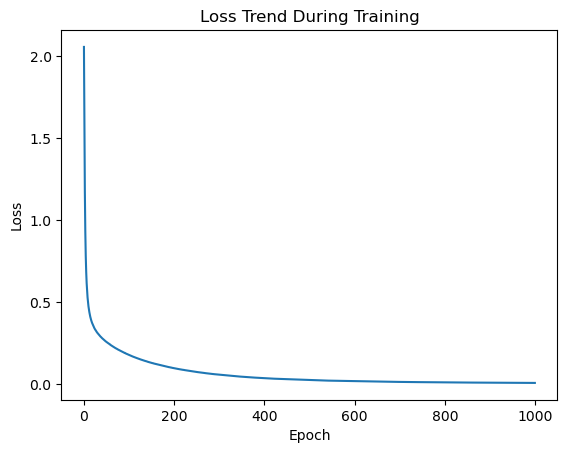



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.96      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


